In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

In [3]:
# --- 1. Load and Prepare Data ---

df = pd.read_csv("/content/drive/MyDrive/Reviews.csv")
df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [5]:
df.shape

(568454, 10)

In [6]:
# Drop specified columns
columns_to_drop = ['ProductId', 'Id', 'ProfileName', 'UserId', 'HelpfulnessDenominator', 'HelpfulnessNumerator', 'Time']
df.drop(columns=columns_to_drop, inplace=True)


In [7]:
# Verify the columns are dropped
df.head()

,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [9]:
# Combine 'summary' and 'text' into a single feature, ensuring all text is properly handled
df['Summary'] = df['Summary'].fillna('').astype(str)
df['Text'] = df['Text'].fillna('').astype(str)
df['Combined_text'] = df['Summary'] + " " + df['Text']

In [10]:
# Preprocess the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['Combined_text'])
sequences = tokenizer.texts_to_sequences(df['Combined_text'])
word_index = tokenizer.word_index

In [11]:
# Pad sequences to ensure uniform input size
max_length = 300
data = pad_sequences(sequences, maxlen=max_length)
data.shape

(568454, 300)

In [12]:
df['Score'].unique()

array([5, 1, 4, 2, 3])

In [13]:
df['Score'] = df['Score'].fillna(df['Score'].mode()[0])

In [14]:
# --- 4. Handle Class Imbalance (If Necessary) ---
# Check for class imbalance (if present)
print("Class distribution before oversampling:", Counter(df['Score']))


Class distribution before oversampling: Counter({5: 363122, 4: 80655, 1: 52268, 3: 42640, 2: 29769})


In [15]:
ros = RandomOverSampler(random_state=42)
data_resampled, labels_resampled = ros.fit_resample(data, df['Score'])

label_counts = Counter(labels_resampled)
print("Class distribution after oversampling:",label_counts)

Class distribution after oversampling: Counter({5: 363122, 1: 363122, 4: 363122, 2: 363122, 3: 363122})


In [16]:
from tensorflow.keras.utils import to_categorical
# Encode labels (after oversampling)
label_encoder = LabelEncoder()
labels_resampled = label_encoder.fit_transform(labels_resampled)
labels_resampled = to_categorical(labels_resampled, num_classes=5)

In [17]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(data_resampled, labels_resampled, test_size=0.2, random_state=42)

In [18]:
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

x_train shape: (1452488, 300)
x_val shape: (363122, 300)
y_train shape: (1452488, 5)
y_val shape: (363122, 5)


In [19]:
# --- 5. Build the CNN Model ---
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_length))

# Convolutional layers
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 296, 128)          82048     
                                                                 
 max_pooling1d (MaxPooling1  (None, 148, 128)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 146, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 73, 64)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 4672)              0

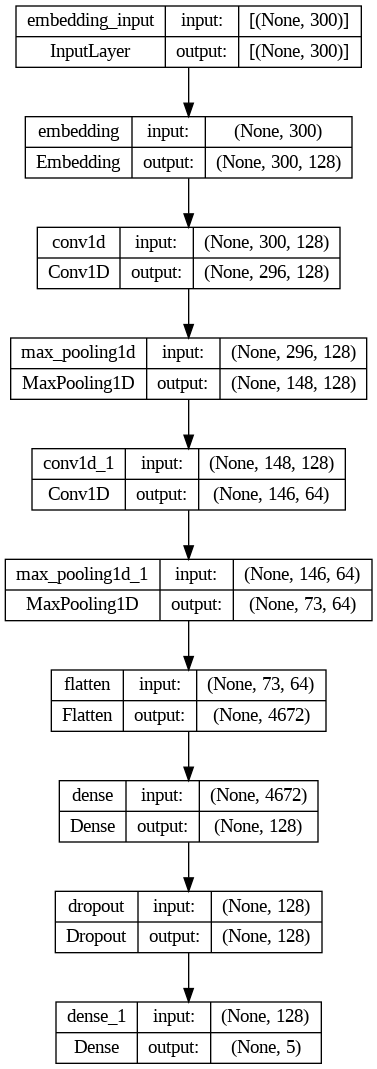

In [20]:
from tensorflow.keras.utils import plot_model

# Assuming your model is already created and named `model`

plot_model(model, to_file="Amazon CNN 5 scores.png", show_shapes=True)  # Adjust filename as needed

In [28]:
from pydot import Dot, Node
from pydot import Dot, Edge  # Import Edge separately

# Assuming your model is already created and named `model`

def create_dot_graph(model):
  graph = Dot(graph_type='digraph')

  layers = [(layer.name, layer.output_shape[1:]) for layer in model.layers]
  # Add layers to graph
  for i, (layer_name, layer_shape) in enumerate(layers):
      label = str(layer_name) + "\n" + str(layer_shape)
      node = Node(str(i), label=label) # Create a Node object
      graph.add_node(node) # Add node to the graph

  # Add edges between layers
  for i, (_, layer_shape) in enumerate(layers[:-1]):
      next_layer_index = i + 1
      # Create Edge object directly
      edge = Edge(str(i), str(next_layer_index))
      graph.add_edge(edge)

  return graph

dot_graph = create_dot_graph(model)
dot_graph.write_png("Amazon CNN 5 scores_pydot.png")  # Adjust filename as needed

In [ ]:
import time
# Start time measurement
start_time = time.time()

# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_val, y_val))

# End time measurement
end_time = time.time()

# Calculate total time
total_time = end_time - start_time
print(f"Total training time: {total_time:.4f} seconds")

Epoch 1/5
45391/45391 [==============================] - 374s 8ms/step - loss: 0.6347 - accuracy: 0.7521 - val_loss: 0.3969 - val_accuracy: 0.8517
Epoch 2/5
45391/45391 [==============================] - 310s 7ms/step - loss: 0.3468 - accuracy: 0.8740 - val_loss: 0.3017 - val_accuracy: 0.8899
Epoch 3/5
45391/45391 [==============================] - 314s 7ms/step - loss: 0.2657 - accuracy: 0.9065 - val_loss: 0.2404 - val_accuracy: 0.9141
Epoch 4/5
45391/45391 [==============================] - 314s 7ms/step - loss: 0.2275 - accuracy: 0.9221 - val_loss: 0.2342 - val_accuracy: 0.9216
Epoch 5/5
45391/45391 [==============================] - 311s 7ms/step - loss: 0.2050 - accuracy: 0.9317 - val_loss: 0.2047 - val_accuracy: 0.9335
Total training time: 1626.6601 seconds


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_val, y_val)
print(f'Validation Accuracy: {accuracy}')

11348/11348 [==============================] - 41s 4ms/step - loss: 0.2047 - accuracy: 0.9335
Validation Accuracy: 0.933537483215332


In [ ]:
# Example prediction
new_texts = ["This product is excellent.", "Not what I expected."]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_data = pad_sequences(new_sequences, maxlen=max_length)

predictions = model.predict(new_data)
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))
print(predicted_labels)

1/1 [==============================] - 0s 235ms/step
[5 2]


In [ ]:
# Predict on the validation set
y_val_pred = model.predict(x_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

11348/11348 [==============================] - 29s 3ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
# Calculate metrics
accuracy = accuracy_score(y_val_true, y_val_pred_classes)
precision = precision_score(y_val_true, y_val_pred_classes, average='weighted')
recall = recall_score(y_val_true, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val_true, y_val_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

print("\nClassification Report:\n", classification_report(y_val_true, y_val_pred_classes))



Accuracy: 0.9335374887778763
Precision: 0.9333912230207716
Recall: 0.9335374887778763
F1 Score: 0.9332012723796268

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     72607
           1       0.98      0.97      0.98     72607
           2       0.94      0.97      0.96     72947
           3       0.87      0.89      0.88     72470
           4       0.91      0.85      0.88     72491

    accuracy                           0.93    363122
   macro avg       0.93      0.93      0.93    363122
weighted avg       0.93      0.93      0.93    363122



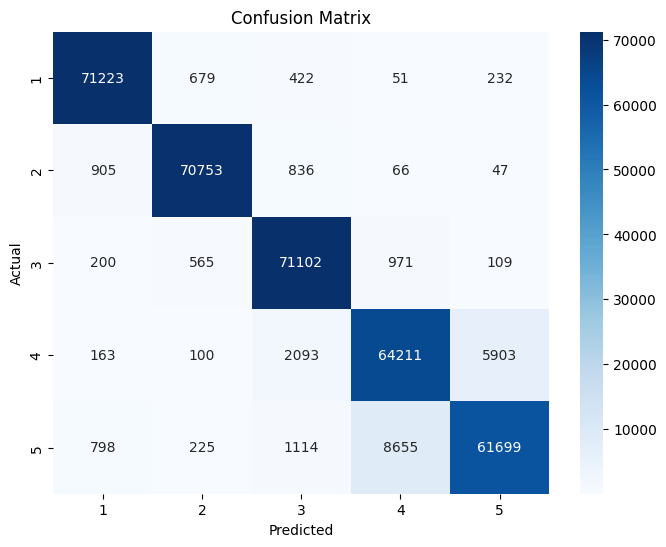

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()